In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy.stats import skew,kurtosis
plt.style.use('fivethirtyeight')

## Important function definitions:

In [2]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [3]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


In [4]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df



In [5]:
def acf_plot(df):
    for col in df.columns:
        plot_acf(df[col])
        plt.title(str(col)+"ACF")
        plt.show()


In [6]:
def pacf_plot(df):
    for col in df.columns:
        plot_pacf(df[col])
        plt.title(str(col)+"PACF")
        plt.show()


In [7]:
def plot_price_series(data):
    for col in data.columns:
        plt.figure(figsize=(20,5))
        data[col].plot()
        plt.title("Price of " + str(col))
        plt.ylabel(str(col))
        plt.show()

In [8]:
def plot_return_series(data):
    for col in data.columns:
        plt.figure(figsize=(20,5))
        data[col].plot()
        plt.title("Log returns/returns^2 of " + str(col))
        plt.ylabel(str(col))
        plt.show()

In [9]:
def ljung_box(residuals):
    for col in residuals.columns:
        print("ljung box test for residuals/returns of series "+ str(col))
        print(sms.acorr_ljungbox(residuals[col], lags=[30], return_df=True))
        print("-"*100)

In [10]:
def arch_lm(residuals):
    for col in residuals.columns:
        print("p value of arch_lm test for residuals/returns of series "+ str(col))
        print(het_arch(residuals[col])[1])
        print("-"*100)

## Data Collection and Preprocessing 

In [11]:
import yfinance as yf
ticker=['INRUSD=X','^BSESN','GC=F']
data=yf.download(ticker,start='2006-01-01',end='2015-12-31')


[*********************100%***********************]  3 of 3 completed


In [12]:
brent=pd.read_csv(r"D:\downloads\IIM Intern\Data Paper 2\brent-daily.csv")
#brent=brent[brent.index>="2006-01-01" && brent.index<="2015-12-31"]

In [13]:
brent.set_index('Date',inplace=True)


In [14]:
start_date='2006-01-01'
end_date='2015-12-31'
brent = brent.loc[start_date:end_date]

In [15]:
brent.index = pd.to_datetime(brent.index)

In [16]:
data=data['Close']

In [17]:
data
data=data[data.index.dayofweek < 5]
brent=brent[brent.index.dayofweek < 5]

In [18]:
data


,GC=F,INRUSD=X,^BSESN
Date,,,
2006-01-02,NaN,0.022232,9390.139648
2006-01-03,530.700012,0.022292,9539.370117
2006-01-04,533.900024,0.022381,9648.080078
2006-01-05,526.299988,0.022386,9617.740234
2006-01-06,539.700012,0.022578,9640.290039
...,...,...,...
2015-12-24,1077.199951,0.015116,25838.710938
2015-12-25,NaN,0.015165,NaN
2015-12-28,1070.500000,0.015165,26034.130859


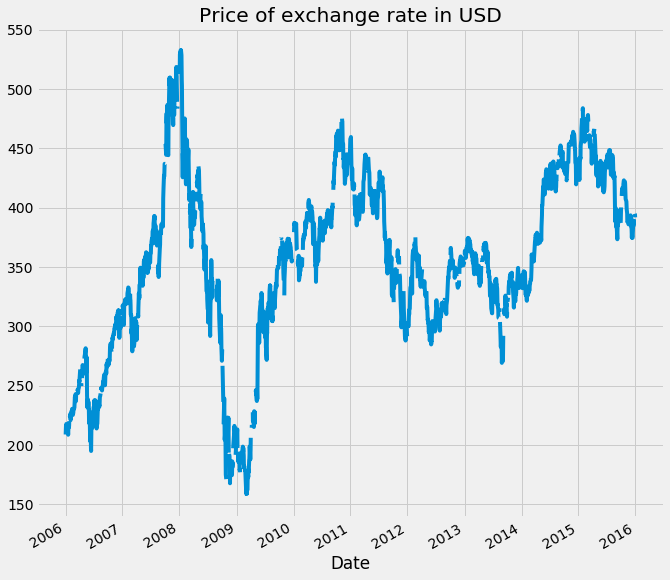

In [19]:
plt.figure(figsize=(10,10))
data['sensex']=data['INRUSD=X']*data['^BSESN']
plt.title("Price of exchange rate in USD")
data.sensex.plot()

In [20]:
#data.columns=["Brent","gold","trus"]

In [21]:
data.isna().sum()
brent.isna().sum()

Price    0
dtype: int64

In [22]:
data=pd.merge(data,brent,how='inner',on='Date')

In [23]:
data

,GC=F,INRUSD=X,^BSESN,sensex,Price
Date,,,,,
2006-01-03,530.700012,0.022292,9539.370117,212.647563,61.51
2006-01-04,533.900024,0.022381,9648.080078,215.937330,61.25
2006-01-05,526.299988,0.022386,9617.740234,215.306491,61.68
2006-01-06,539.700012,0.022578,9640.290039,217.662896,62.43
2006-01-09,549.099976,0.022594,9583.450195,216.526218,62.51
...,...,...,...,...,...
2015-12-23,1069.400024,0.015096,25850.300781,390.234466,35.79
2015-12-24,1077.199951,0.015116,25838.710938,390.584249,37.22
2015-12-28,1070.500000,0.015165,26034.130859,394.815432,37.08


In [24]:
data.columns=["gold","exrate","bse","sensex","brent"]

In [25]:
data=data.reindex(['brent','gold','exrate','sensex','bse'],axis=1)

In [26]:
data

,brent,gold,exrate,sensex,bse
Date,,,,,
2006-01-03,61.51,530.700012,0.022292,212.647563,9539.370117
2006-01-04,61.25,533.900024,0.022381,215.937330,9648.080078
2006-01-05,61.68,526.299988,0.022386,215.306491,9617.740234
2006-01-06,62.43,539.700012,0.022578,217.662896,9640.290039
2006-01-09,62.51,549.099976,0.022594,216.526218,9583.450195
...,...,...,...,...,...
2015-12-23,35.79,1069.400024,0.015096,390.234466,25850.300781
2015-12-24,37.22,1077.199951,0.015116,390.584249,25838.710938
2015-12-28,37.08,1070.500000,0.015165,394.815432,26034.130859


In [27]:
#data['Date']=pd.to_datetime(data['Date'])

In [28]:
#data.set_index('Date',inplace=True)

In [29]:
data.dropna(how='any',inplace=True)

In [30]:
data.isna().sum()

brent     0
gold      0
exrate    0
sensex    0
bse       0
dtype: int64

In [31]:
data.drop('bse',axis=1,inplace=True)

## Visualization  and Statistics of the prices

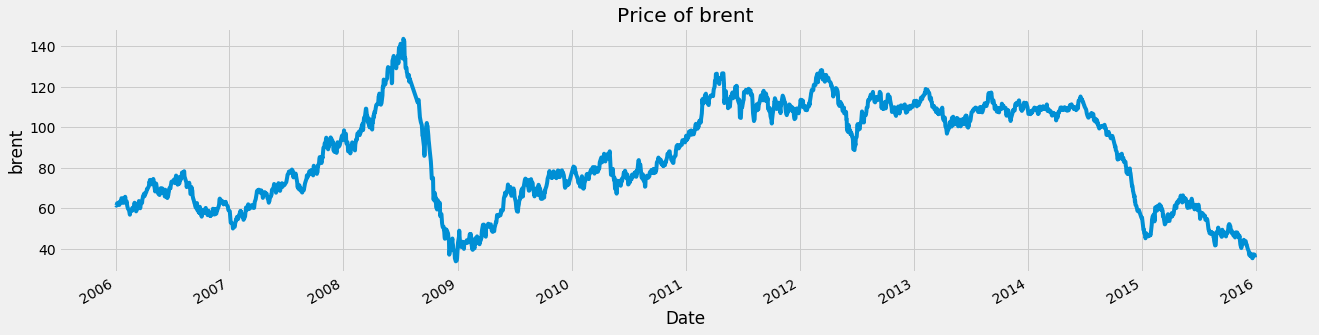

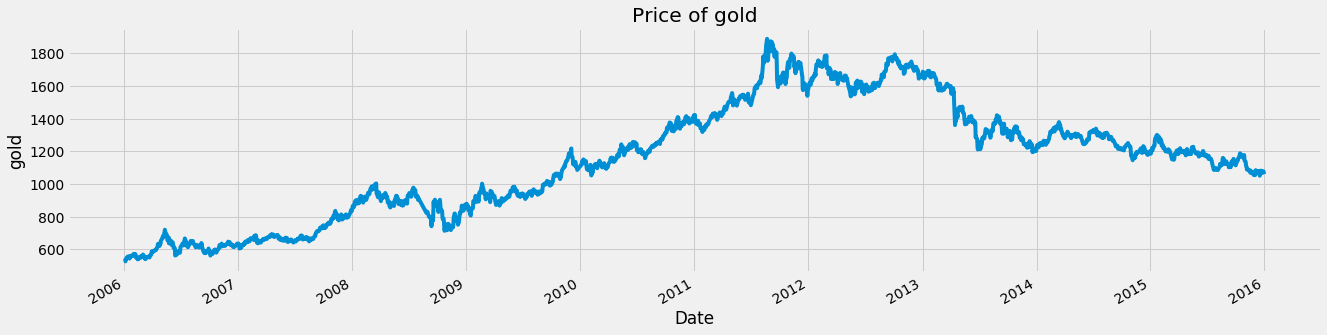

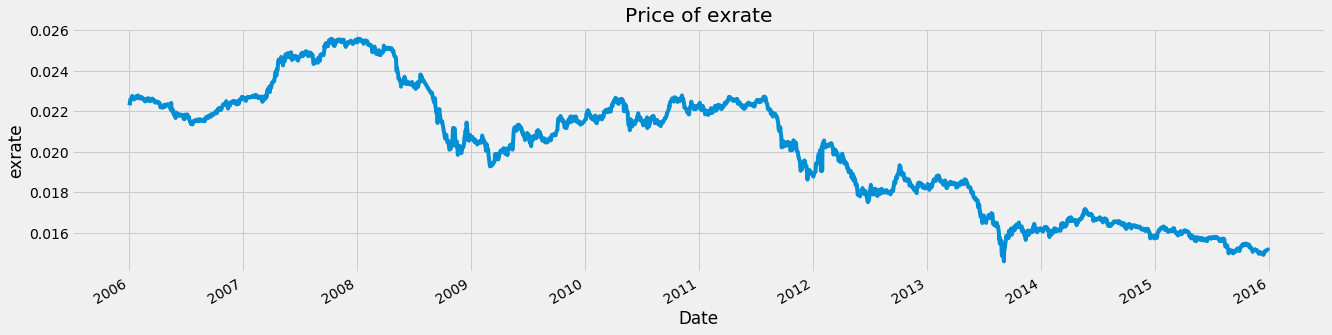

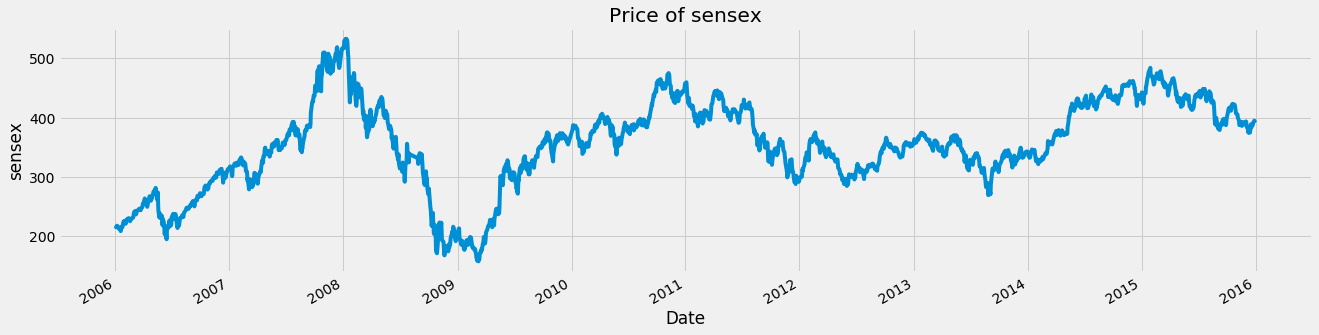

In [32]:
plot_price_series(data)

### Pairplot of prices

<Figure size 720x360 with 0 Axes>

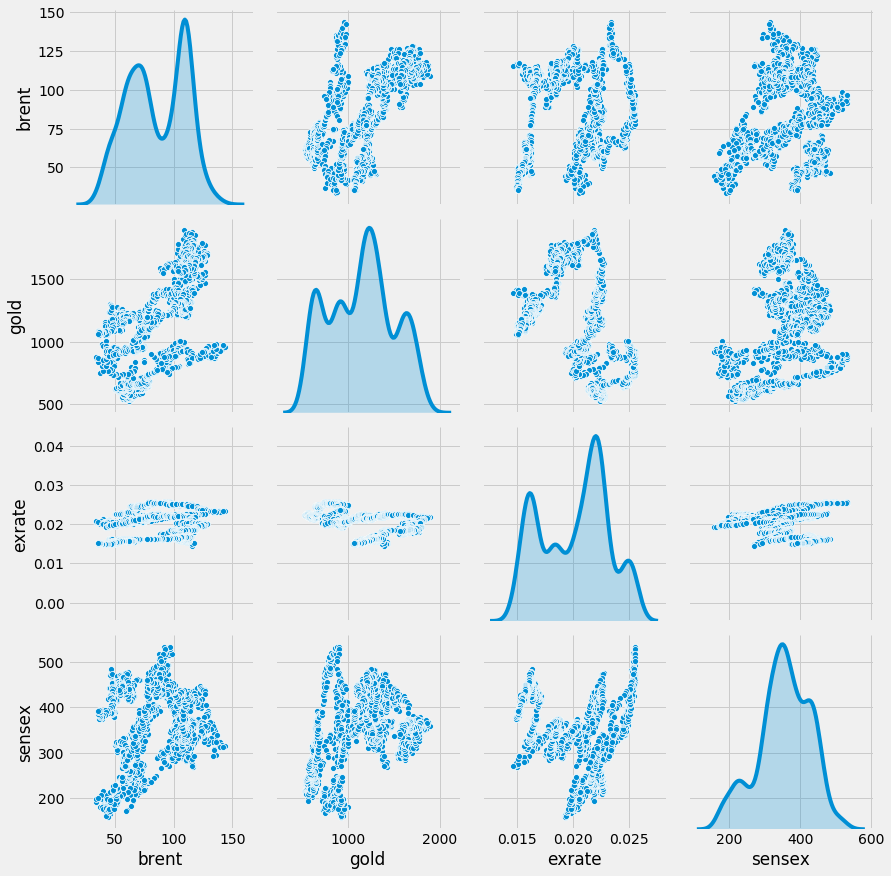

In [33]:
plt.figure(figsize=(10,5))
sns.pairplot(data,diag_kind='kde',height=3)

## Heat Map for correlation

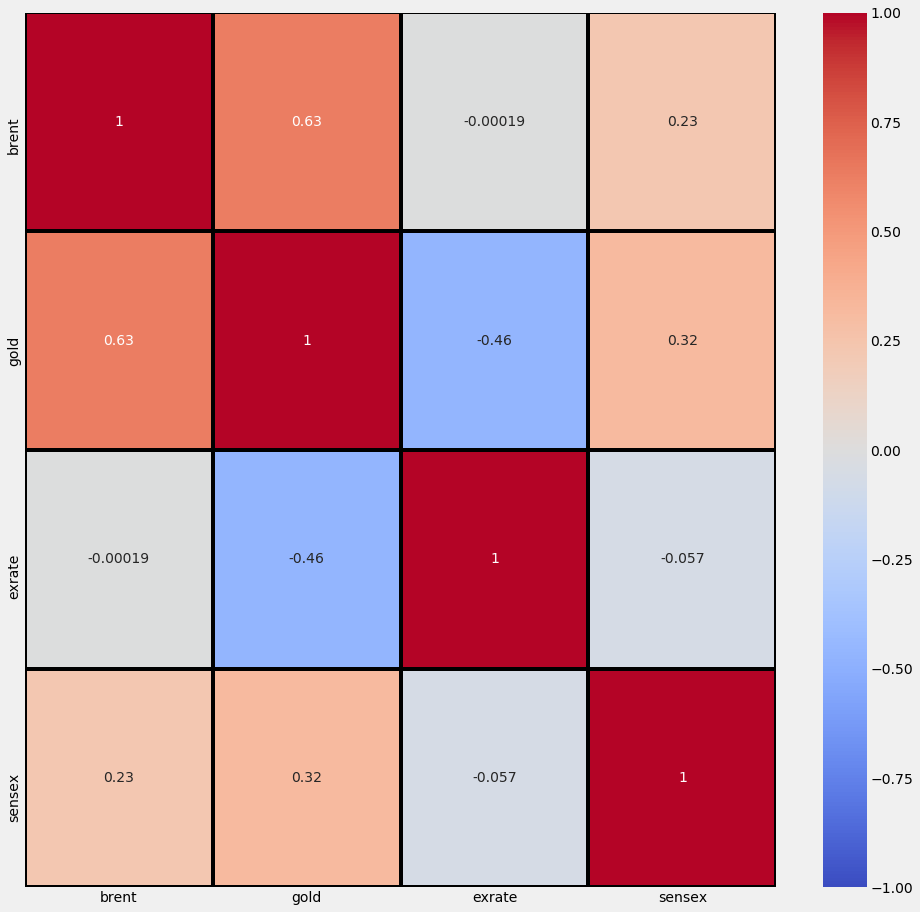

In [34]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

#### Gold and Exchange rate seem to be negatively correlated and crude, gold are highly correlated

In [35]:
data.describe()

,brent,gold,exrate,sensex
count,2326.000000,2326.000000,2326.000000,2326.000000
mean,85.717244,1146.191401,0.020169,354.538256
std,24.562719,349.577800,0.003004,73.390618
min,33.730000,526.299988,0.014575,157.576223
25%,65.090000,880.599976,0.016965,313.271567
50%,83.635000,1185.099976,0.020794,356.516879
75%,108.980000,1377.375000,0.022360,411.442650
max,143.680000,1888.699951,0.025579,532.739463


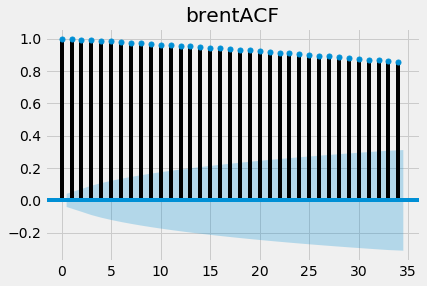

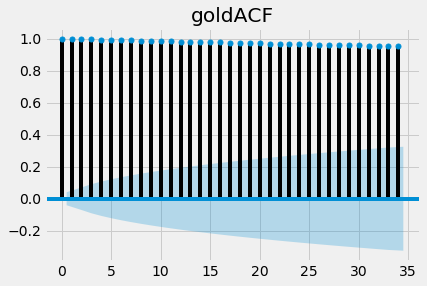

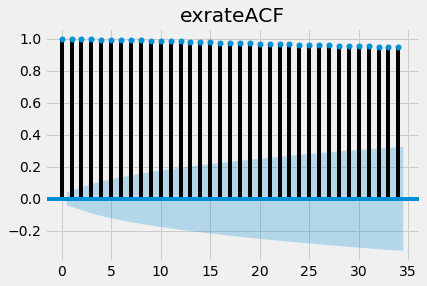

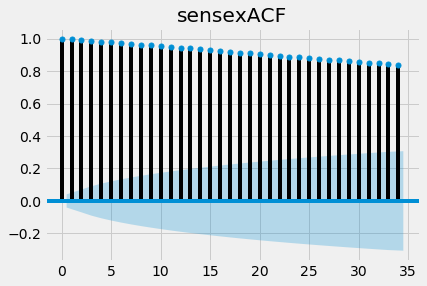

In [36]:
acf_plot(data)

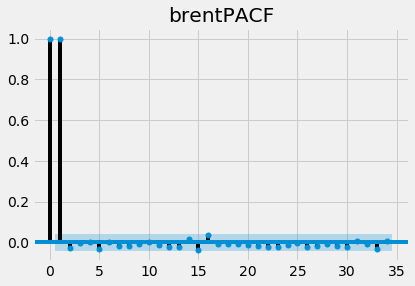

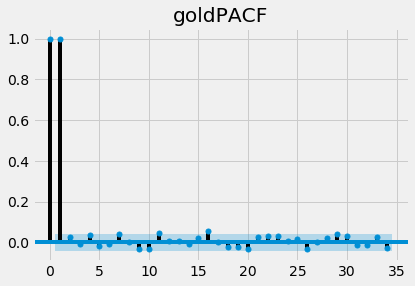

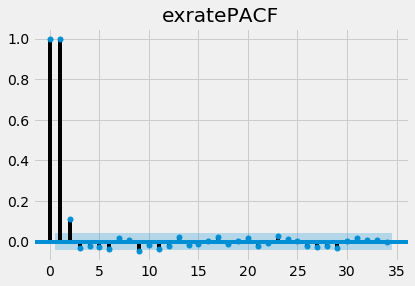

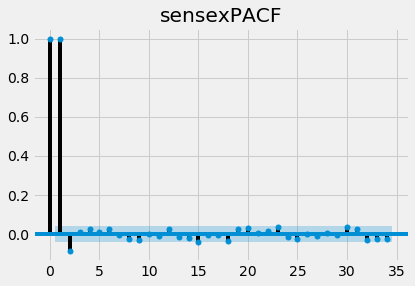

In [37]:
pacf_plot(data)

#### For Prices as we can see the ACF is decreasing but never below the significant range and PACF of one lag being highly significant indicating Auto regressive order of 1

In [38]:
for name, column in data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "brent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.2153
 No. Lags Chosen       = 1
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.667. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "gold" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.7094
 No. Lags Chosen       = 22
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.4263. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "exrate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit

#### This is the Augmented dickey fuller test which provides the evidence of non stationarity in all the prices series and therefore requirement of differencing for prediction

## Visualization and Statistics for log returns of the 4 time series 

In [39]:
log_returns=np.log(data) - np.log(data.shift(1))

In [40]:
log_returns.dropna(how='all',inplace=True)

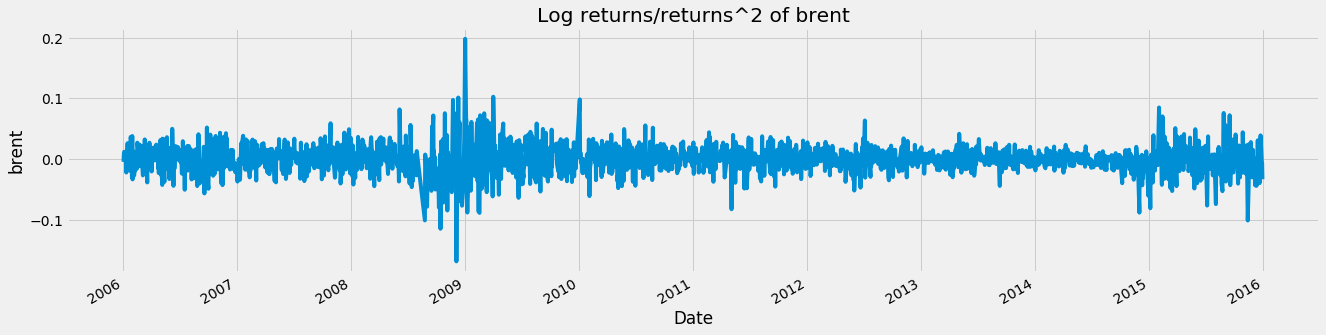

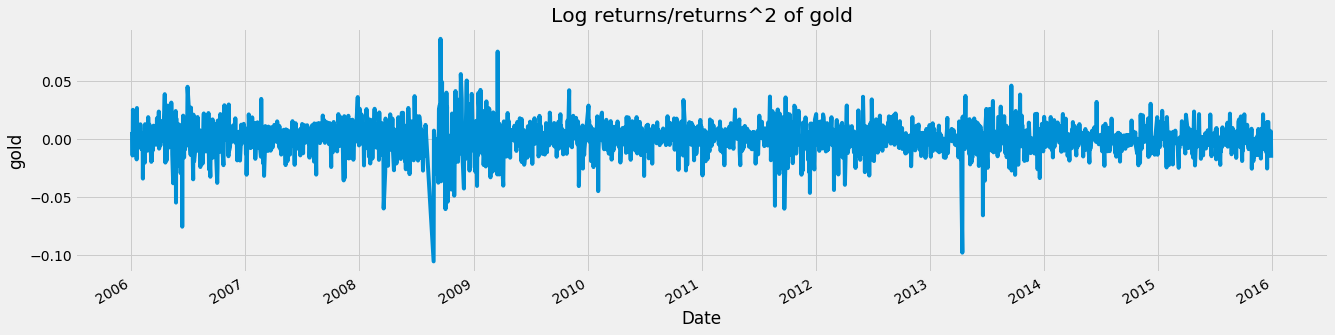

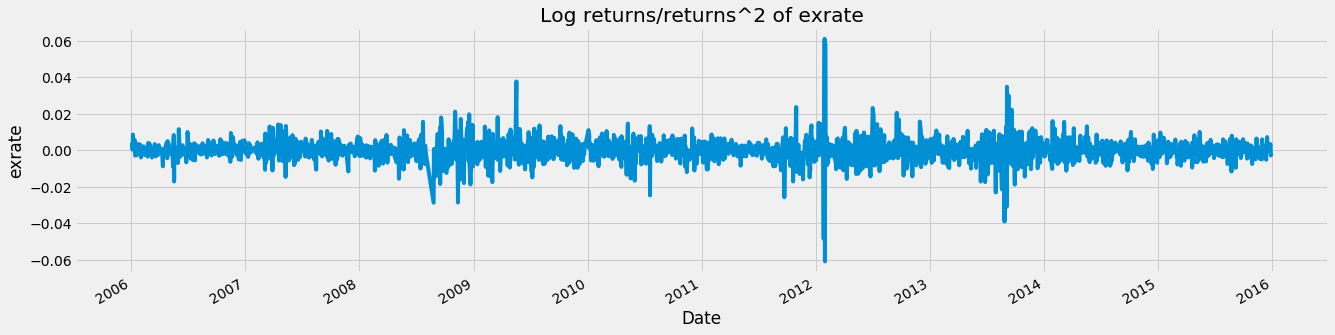

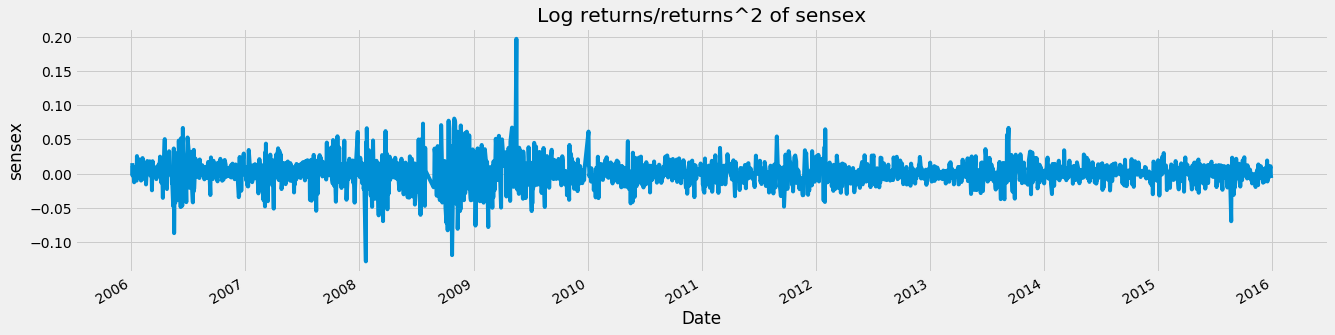

In [41]:
plot_return_series(log_returns)

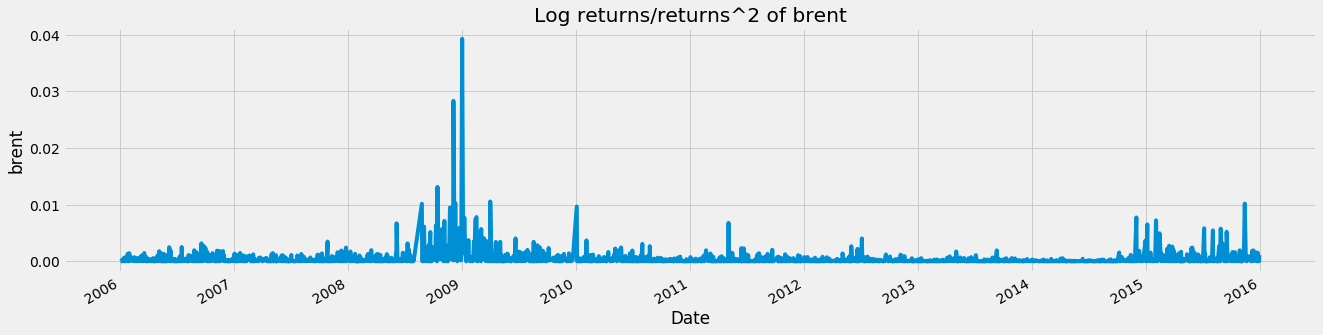

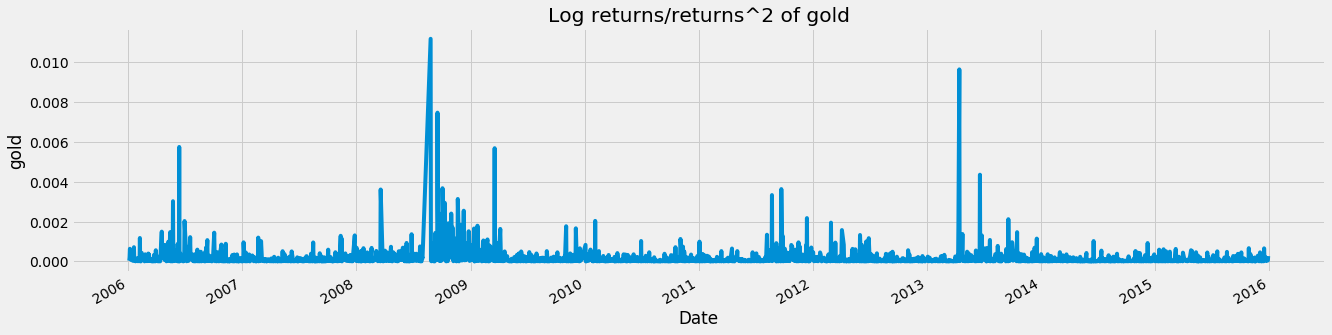

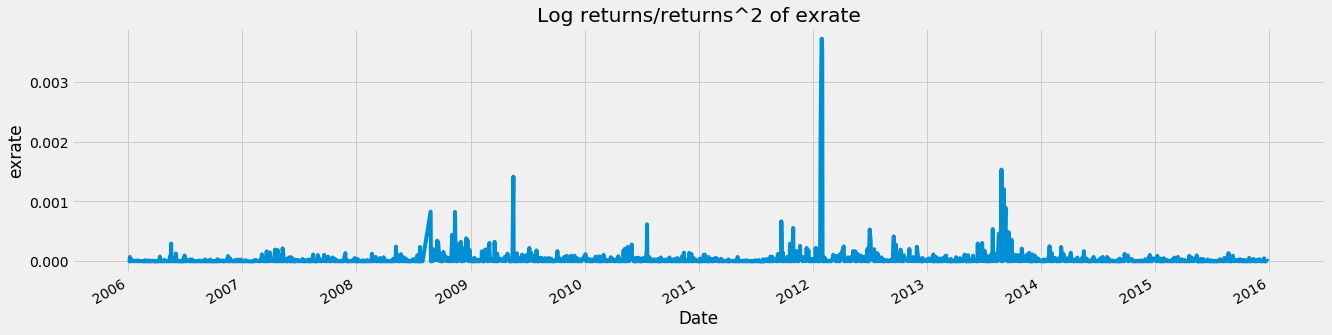

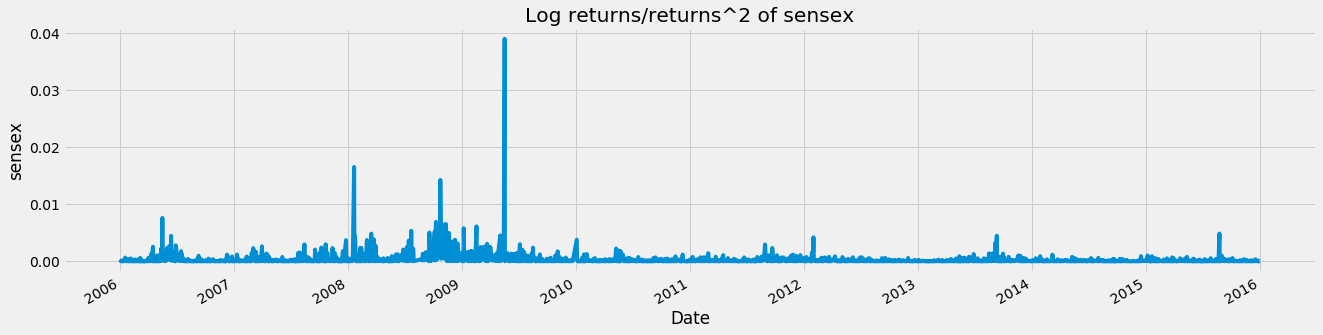

In [42]:
plot_return_series(log_returns**2)

## Few points to note are :
#### 1.) All financial time series log returns have stylized fact of volatility clustering that implies period of high volatility are followed by high volatility and low are followed by low volatility
#### 2.) Crude oil volatility has high during 2008 and 2016 due to the brexit voting 

<Figure size 720x360 with 0 Axes>

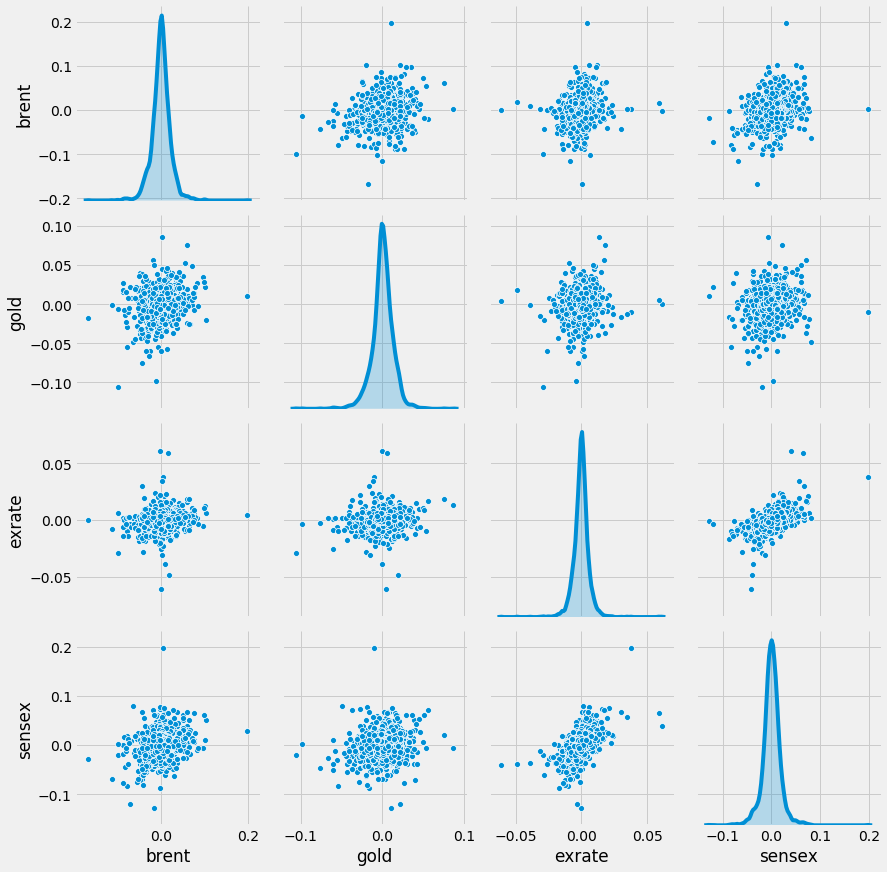

In [43]:
plt.figure(figsize=(10,5))
sns.pairplot(log_returns,diag_kind='kde',height=3)

### Distribution of the data now looks closer to normal with a lot of kurtosis as seen visually

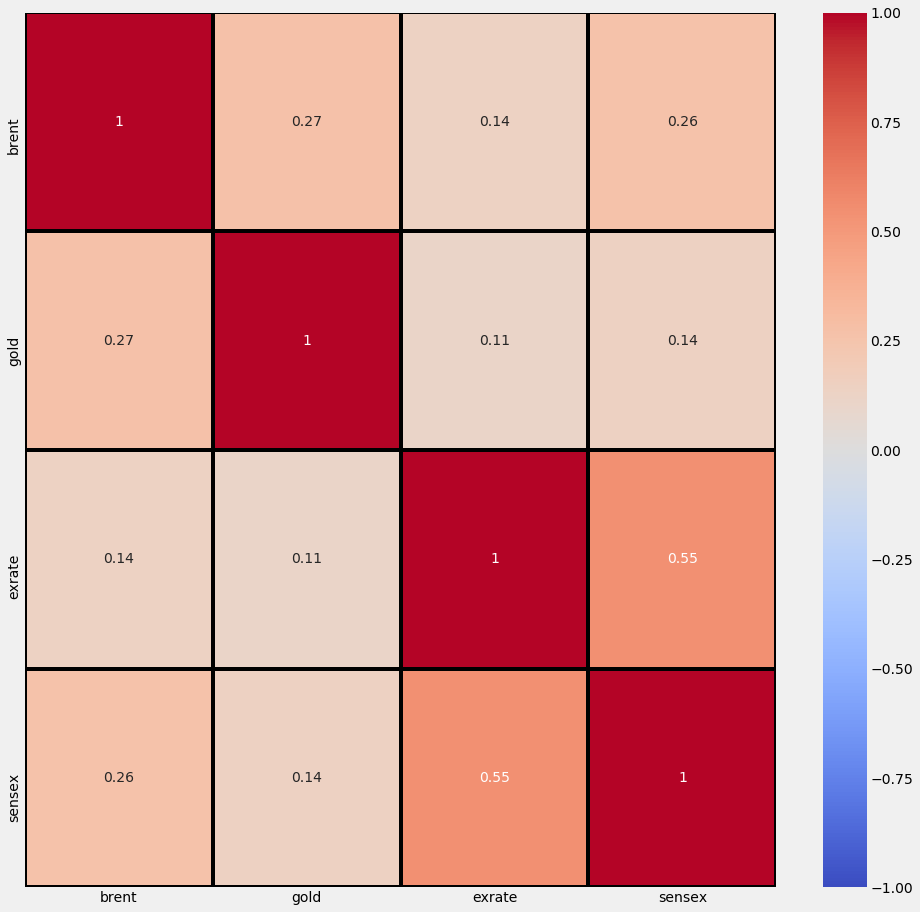

In [44]:
plt.figure(figsize=(15,15))
sns.heatmap(log_returns.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

#### Sensex and exchange rate now have high correlation and then gold,crude  also have linear relationship but these only provide a static correlation and  do not highlight the changes in correlation which happen over a period of time

### Descriptive Statistics

In [45]:
kurt=pd.DataFrame(kurtosis(log_returns).reshape(-1,4),columns=['brent','gold','exrate','sensex'])
skew=pd.DataFrame(skew(log_returns).reshape(-1,4),columns=['brent','gold','exrate','sensex'])

In [46]:
descrp=log_returns.describe()

In [47]:
kurt.index=['Kurtosis']
skew.index=['Skewness']

In [48]:
descrp=pd.concat([descrp,kurt,skew],axis=0)
descrp

,brent,gold,exrate,sensex
count,2325.000000,2325.000000,2325.000000,2325.000000
mean,-0.000235,0.000298,-0.000168,0.000263
std,0.021892,0.013415,0.006049,0.018667
min,-0.168320,-0.105737,-0.060972,-0.128621
25%,-0.010796,-0.005766,-0.002946,-0.008477
50%,0.000089,0.000396,0.000000,0.000535
75%,0.010896,0.007323,0.002624,0.009684
max,0.198190,0.086432,0.060972,0.197512
Kurtosis,6.755518,6.020119,17.367927,9.051730
Skewness,0.047832,-0.566664,0.075196,0.195430


## Jacque Bera test for normality of log returns

#### The null hypothesis for the test is that the data is normally distributed; the alternate hypothesis is that the data does not come from a normal distribution.If the data comes from a normal distribution, the JB statistic asymptotically has a chi-squared distribution with two degrees of freedom, so the statistic can be used to test the hypothesis that the data are from a normal distribution.

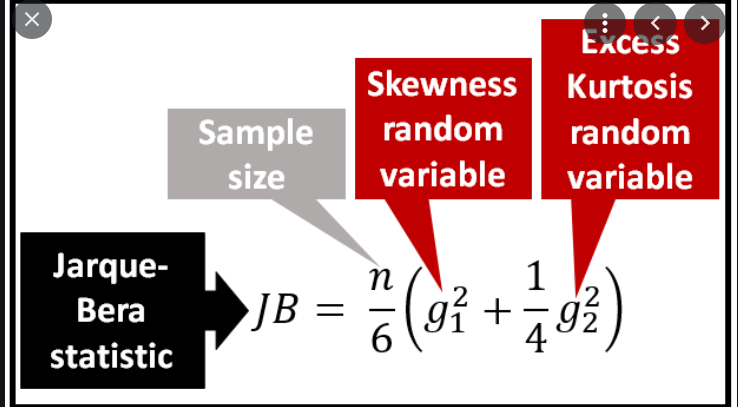

In [49]:
name = ['Jarque-Bera test', 'Chi-squared(2) p-value', 'Skewness', 'Kurtosis']
test = sms.jarque_bera(log_returns)
lzip(name, test)

[('Jarque-Bera test',
  array([ 4421.97274031,  3635.35733908, 29224.03937028,  7952.13878271])),
 ('Chi-squared(2) p-value', array([0., 0., 0., 0.])),
 ('Skewness', array([ 0.04783155, -0.56666383,  0.07519552,  0.19543023])),
 ('Kurtosis', array([ 9.75551766,  9.02011941, 20.36792693, 12.05173033]))]

#### Descriptive stats indicates all 4 series have approximately 0 mean but they are not normally distributed as we can see p value : 0
#### This serves as a hint for using GARCH models as it accounts for fat tails in its model if the returns were normally distributed then there would have been less volatility clustering

## ACF and PACF plots for log returns

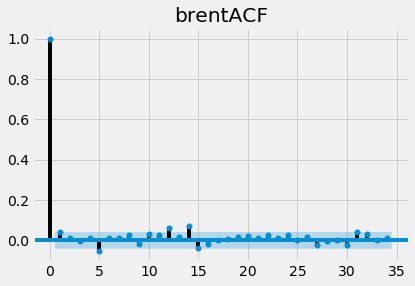

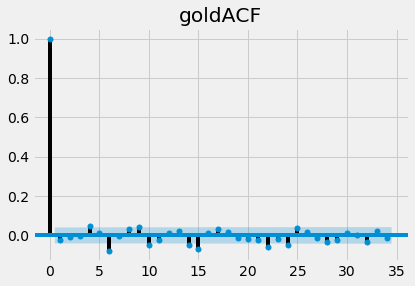

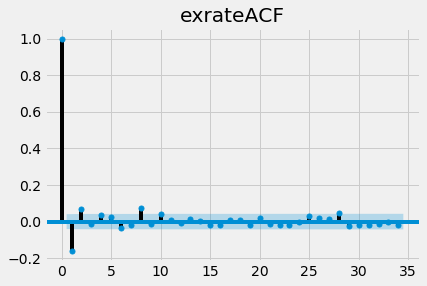

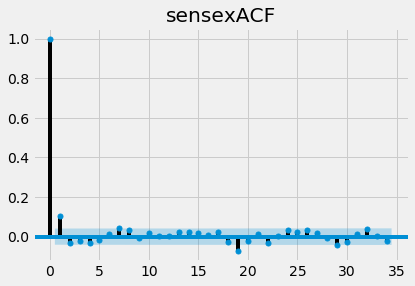

In [50]:
acf_plot(log_returns)

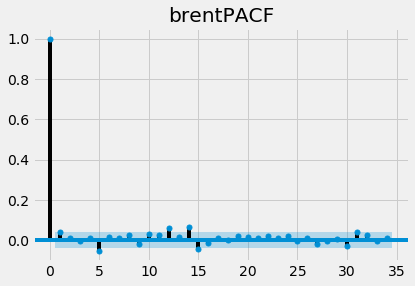

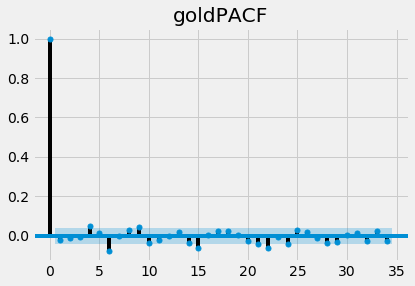

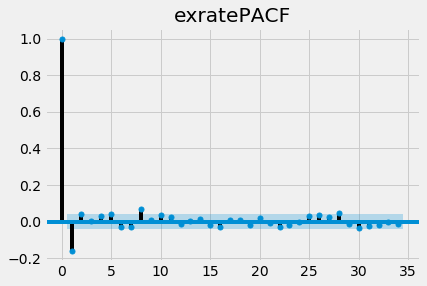

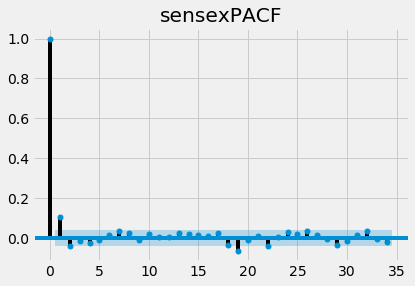

In [51]:
pacf_plot(log_returns)

## Few Points to Note :
#### ACF for all four series have some significant lag correlation.
#### PACF for all 4 series are very significant indicating requirement of auto regressive model for removing the serial correlations between the lags

## Ljung Box Test

#### The null hypothesis of Ljung-Box test is: the data is independently distributed. If the p-value is larger than the specified significance level, the null hypothesis cannot be rejected. In other words, there is no clear sign of autocorrelations and the model is valid.


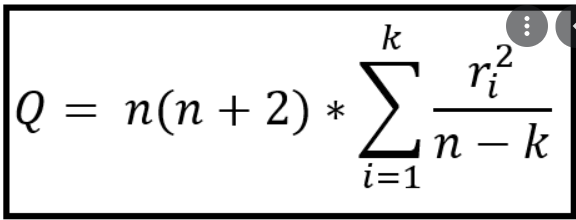

In [52]:
ljung_box(log_returns)

ljung box test for residuals/returns of series brent
      lb_stat  lb_pvalue
30  51.641959   0.008322
----------------------------------------------------------------------------------------------------
ljung box test for residuals/returns of series gold
      lb_stat     lb_pvalue
30  83.039124  7.158105e-07
----------------------------------------------------------------------------------------------------
ljung box test for residuals/returns of series exrate
       lb_stat     lb_pvalue
30  113.114433  1.420025e-11
----------------------------------------------------------------------------------------------------
ljung box test for residuals/returns of series sensex
      lb_stat  lb_pvalue
30  74.421651   0.000012
----------------------------------------------------------------------------------------------------


#### Ljung box tests rejects the null and therefore there exists serial autocorrelations

## Modelling all the Time series

### Since we have multiple time series there is always a possibility of one time series granger causing other time series and we should test this by granger causality test.

#### Note : Here I have used the word granger causes instead of direct causation because causation would be too bold of a statement

### Granger Causality test

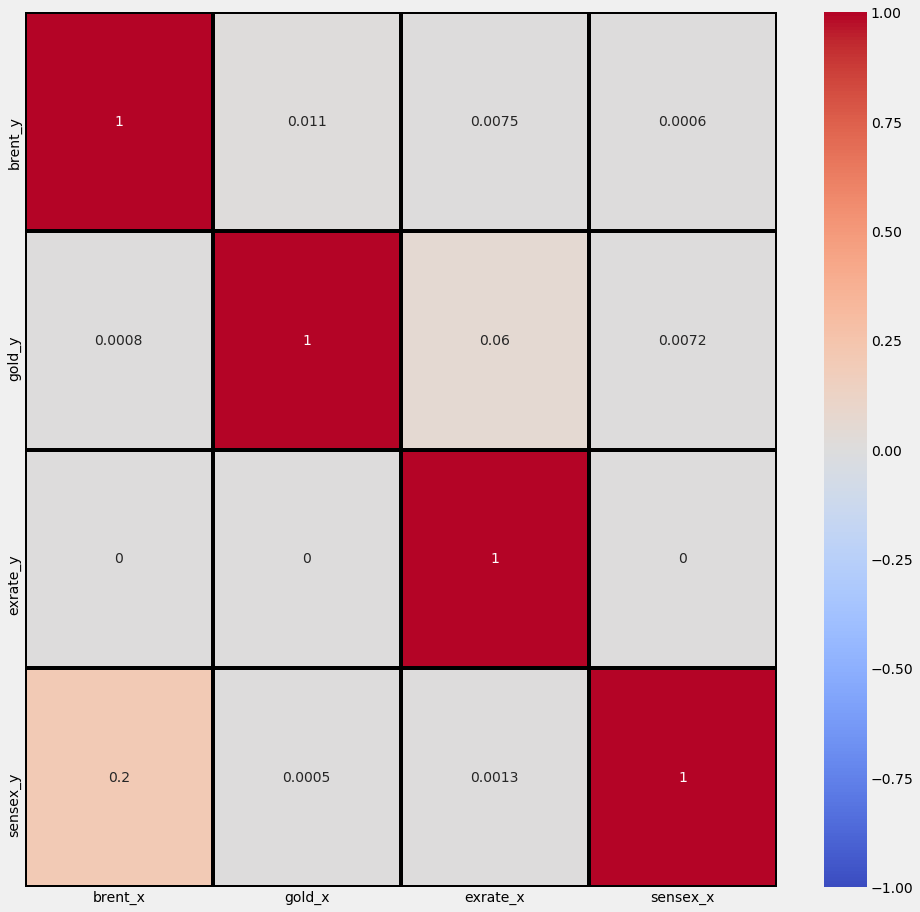

In [53]:
plt.figure(figsize=(15,15))
sns.heatmap(grangers_causation_matrix(log_returns,log_returns.columns), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')


### The row are the Response (Y) and the columns are the predictor series (X).

### For example, if you take the value 0.011 in (row 1, column 2), it refers to the p-value of gold_x causing brent_y. Whereas, the 0.0008 in (row 2, column 1) refers to the p-value of brent_x causing gold_y.

### So, how to interpret the p-values?

#### If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

#### All the color codes are in grey implying that almost all series granger causes each other which gives a good reason for using vector auto regression models

## Johanesen Cointegration test

In [54]:
cointegration_test(log_returns)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
brent  ::  1494.02   > 40.1749   =>   True
gold   ::  1083.03   > 24.2761   =>   True
exrate ::  692.42    > 12.3212   =>   True
sensex ::  332.34    > 4.1296    =>   True


#### Test suggests that cointegration exists

### ADF Test

In [55]:
for name, column in log_returns.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "brent" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.895
 No. Lags Chosen       = 14
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "gold" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.7337
 No. Lags Chosen       = 23
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "exrate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    =

#### All four series are stationary

## Implementation of VAR models


In [56]:
import statsmodels.tsa.api as smt
var_model = smt.VAR(log_returns)
res = var_model.select_order(maxlags=30,trend='c') ## Lag selection process
print(res.summary())

C:\Users\Nishant\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -34.93      -34.92   6.751e-16      -34.93
1      -35.04*     -34.99*  6.072e-16*     -35.02*
2       -35.04      -34.95   6.084e-16      -35.00
3       -35.03      -34.90   6.097e-16      -34.99
4       -35.03      -34.86   6.098e-16      -34.97
5       -35.03      -34.82   6.134e-16      -34.95
6       -35.03      -34.78   6.127e-16      -34.94
7       -35.02      -34.73   6.157e-16      -34.92
8       -35.02      -34.69   6.180e-16      -34.90
9       -35.02      -34.65   6.207e-16      -34.88
10      -35.01      -34.60   6.218e-16      -34.86
11      -35.01      -34.56   6.227e-16      -34.85
12      -35.01      -34.52   6.242e-16      -34.83
13      -35.00      -34.47   6.280e-16      -34.81
14      -35.00      -34.43   6.291e-16      -34.79
15      -35.01      -34.40   6.268e-16      -34.78
16      -35.00      -34.35   6.

In [57]:
result=var_model.fit(maxlags=1)

In [58]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Jun, 2021
Time:                     20:04:44
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -35.0045
Nobs:                     2324.00    HQIC:                  -35.0360
Log likelihood:           27562.3    FPE:                5.97371e-16
AIC:                     -35.0540    Det(Omega_mle):     5.92258e-16
--------------------------------------------------------------------
Results for equation brent
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.000244         0.000454           -0.539           0.590
L1.brent          0.015433         0.022095            0.698           0.485
L1.gold           0.036376         0.035176            1.034           0.301

In [59]:
residuals=result.resid

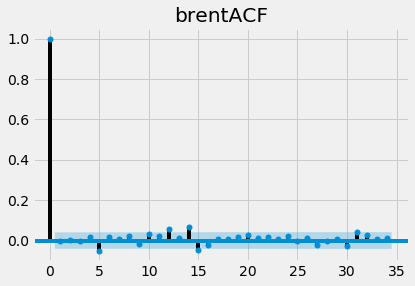

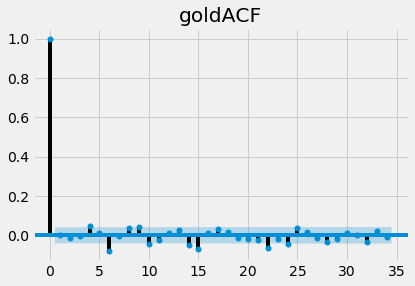

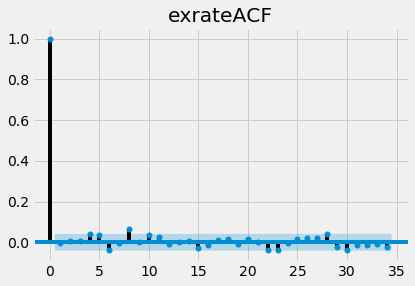

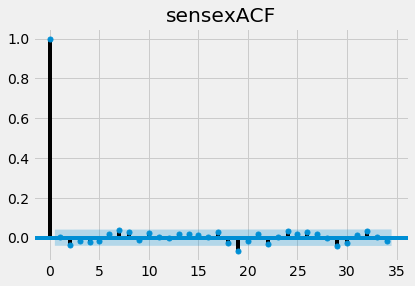

In [61]:
acf_plot(residuals)

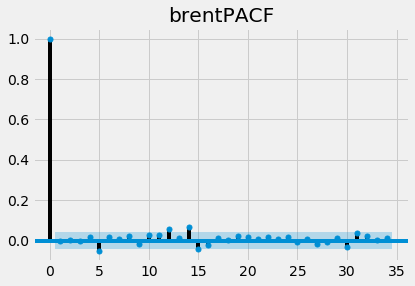

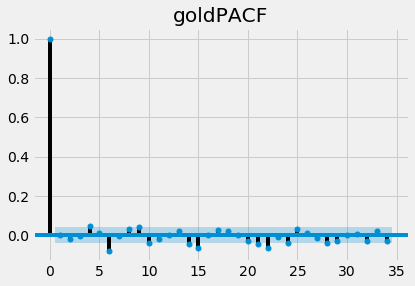

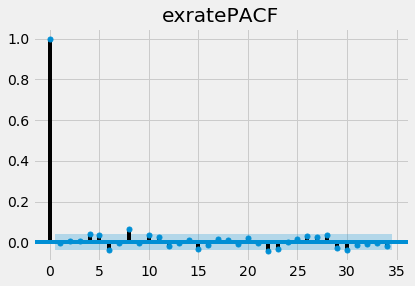

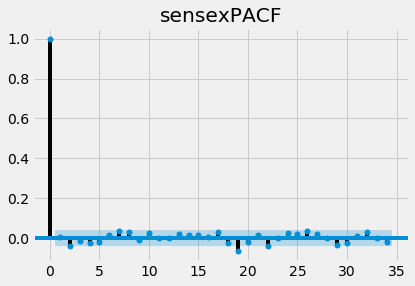

In [62]:
pacf_plot(residuals)

In [63]:
ljung_box(residuals)

ljung box test for residuals/returns of series brent
      lb_stat  lb_pvalue
30  47.402482   0.022722
----------------------------------------------------------------------------------------------------
ljung box test for residuals/returns of series gold
      lb_stat     lb_pvalue
30  83.901737  5.348850e-07
----------------------------------------------------------------------------------------------------
ljung box test for residuals/returns of series exrate
      lb_stat  lb_pvalue
30  46.388691   0.028521
----------------------------------------------------------------------------------------------------
ljung box test for residuals/returns of series sensex
      lb_stat  lb_pvalue
30  44.753552   0.040688
----------------------------------------------------------------------------------------------------


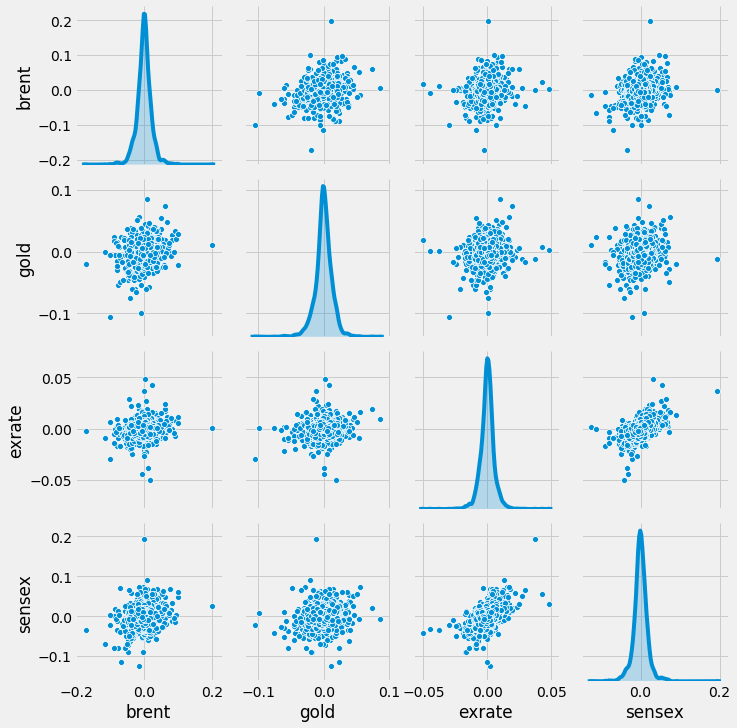

In [64]:
sns.pairplot(residuals,diag_kind='kde')

## Lagrange Multiplier Test for testing ARCH effects in residuals

#### Null hypothesis : No ARCH effects present 

In [65]:
from statsmodels.stats.diagnostic import het_arch

In [66]:
arch_lm(residuals)

p value of arch_lm test for residuals/returns of series brent
3.087165739000603e-73
----------------------------------------------------------------------------------------------------
p value of arch_lm test for residuals/returns of series gold
2.6917365261609446e-27
----------------------------------------------------------------------------------------------------
p value of arch_lm test for residuals/returns of series exrate
7.393291832506176e-131
----------------------------------------------------------------------------------------------------
p value of arch_lm test for residuals/returns of series sensex
7.821655157406932e-35
----------------------------------------------------------------------------------------------------


C:\Users\Nishant\AppData\Roaming\Python\Python37\site-packages\statsmodels\stats\diagnostic.py:625: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setmaxlags or period to silence this warning.
  FutureWarning)


### NULL hypothesis is rejected indicating significant arch effects therefore we have to model for heteroscedasticity

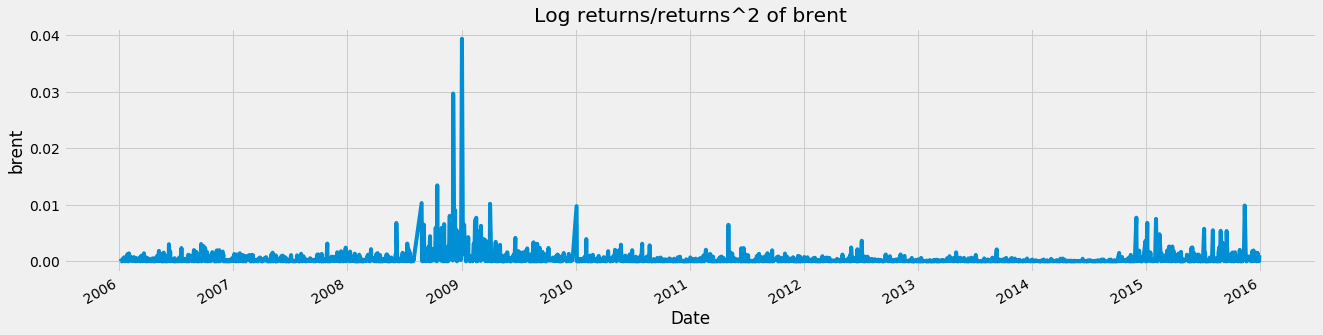

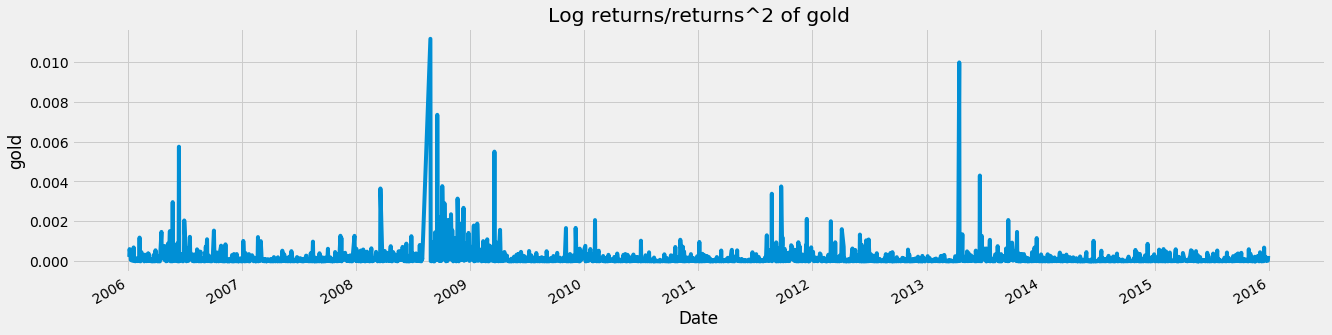

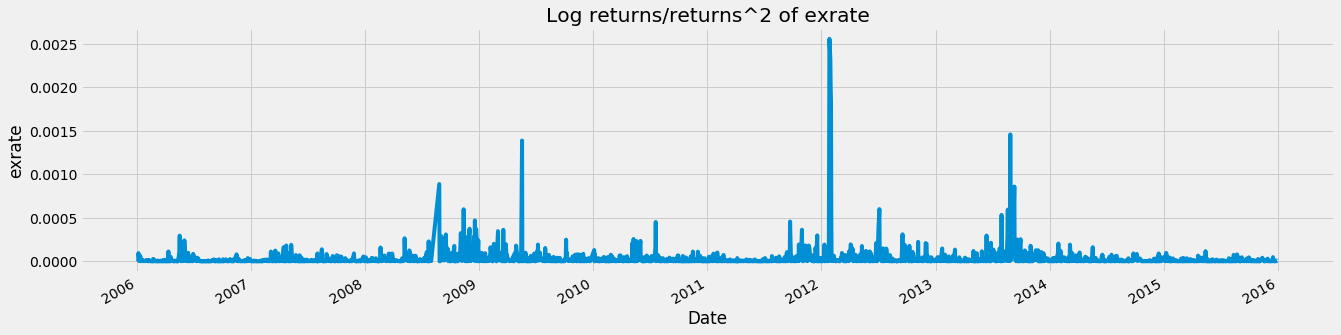

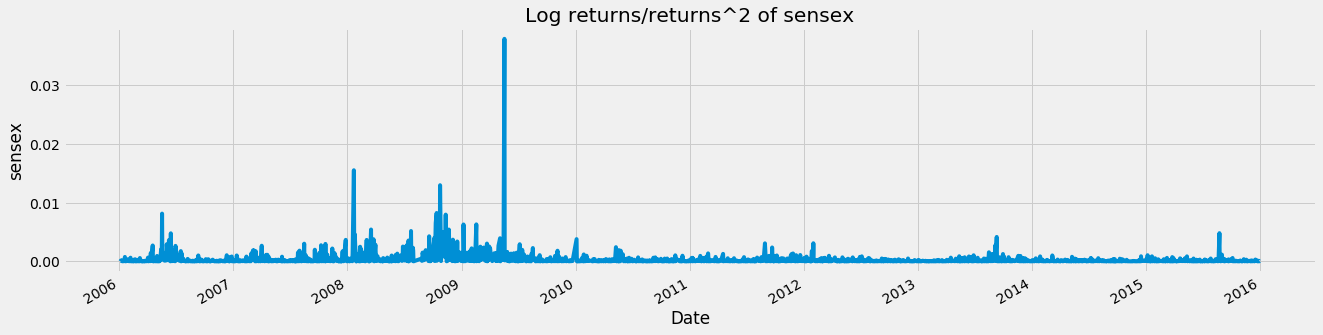

In [67]:
plot_return_series(residuals**2)

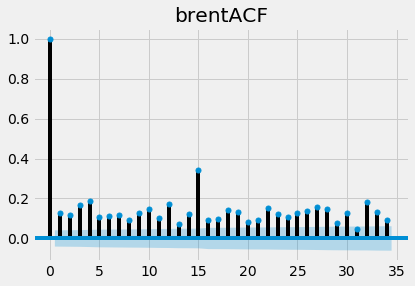

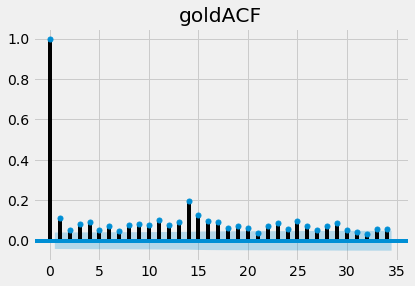

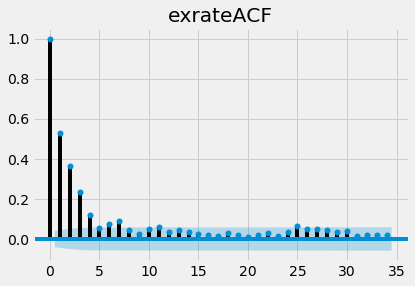

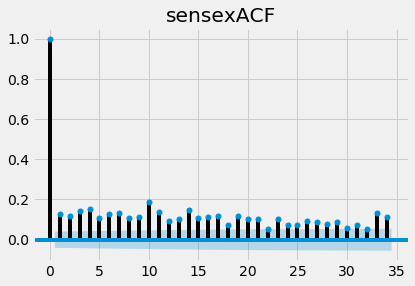

In [68]:
acf_plot(residuals**2)

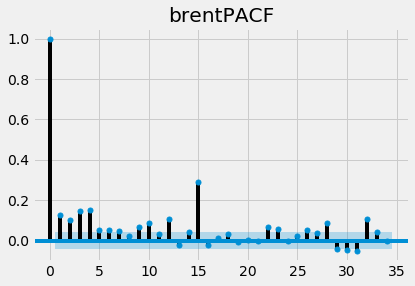

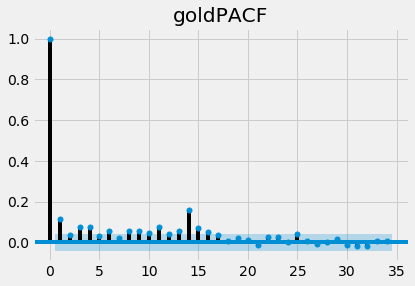

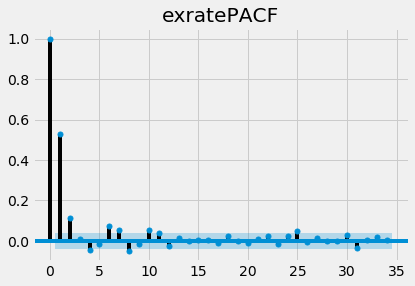

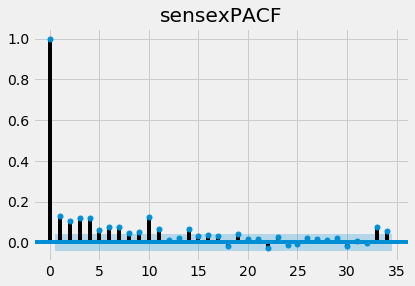

In [69]:
pacf_plot(residuals**2)

In [70]:
residuals.to_csv('Var residuals_lag1')

In [70]:
#log_returns.to_csv('log_india')